In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify
import random
from scipy import ndimage
import glob
import cv2
from tqdm import tqdm
from PIL import Image
import torch
from segment_anything import sam_model_registry, SamPredictor
from torch.utils.data import DataLoader
from transformers import SamModel, SamConfig, SamProcessor
from skimage.filters import threshold_local
from easyocr import Reader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from difflib import get_close_matches
import re
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\adamain\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
from torch.utils.data import Dataset



c:\Users\adamain\.conda\envs\imgid\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\adamain\.conda\envs\imgid\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
# imshow(String titleofimage, image, float size)
def imshow(title = "Image", image = None, size = 10):
    w= image.shape[0]
    h=image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

In [4]:
#Get bounding boxes from mask to identify where data is on images
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [5]:
class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["image"])
    
    # Convert the image to RGB format
    #image = image.convert("RGB") #This line was added to make sure images are read in expected format

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [7]:
def load_and_preprocess(image_path):
    # Read as grayscale but convert to RGB-like format for SAM
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Handle 16-bit TIFF normalization if needed
    if img.dtype == np.uint16:
        img = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))
    
    # Convert to 3-channel "RGB" by stacking grayscale channels
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img_rgb, img  # Return both RGB and original grayscale

In [8]:
def auto_detect_prompt(gray_image, box_width=500, box_height=600, step=40):
    height, width = gray_image.shape
    max_score = -1
    best_box = None

    # Search lower-left quadrant
    x_start = 0
    x_end = width // 2 - box_width
    y_start = height // 2
    y_end = height - box_height

    for y in range(y_start, y_end, step):
        for x in range(x_start, x_end, step):
            patch = gray_image[y:y+box_height, x:x+box_width]
            if patch.shape[0] != box_height or patch.shape[1] != box_width:
                continue

            # Split into top and bottom halves
            top = patch[:box_height // 2, :]
            bottom = patch[box_height // 2:, :]

            mean_top = np.mean(top)
            mean_bottom = np.mean(bottom)
            score = abs(mean_top - mean_bottom)

            if score > max_score:
                max_score = score
                best_box = [x, y, x + box_width, y + box_height]

    if best_box:
        x1, y1, x2, y2 = best_box
        # Keep only the light half (bottom)
        mid_y = y1 + (y2 - y1) // 2
        return [x1, mid_y, x2, y2]
    else:
        # Fallback to a reasonable guess (bottom-left)
        cx = int

In [9]:
def targetBox(dataset, image_path):
    # Load SAM model
    # sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b.pth")  # Download the .pth file first
    # sam.to("cuda" if torch.cuda.is_available() else "cpu")
    # # Initialize the processor
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    train_dataset = SAMDataset(dataset=dataset, processor=processor)
    train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False, collate_fn=collate_fn)
    model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    # Create an instance of the model architecture with the loaded configuration
    my_mito_model = SamModel(config=model_config)
    #Update the model by loading the weights from saved file.
    device = "cuda" if torch.cuda.is_available() else "cpu"
    my_mito_model.to(device)
    test_image, original_grayscale = load_and_preprocess(image_path)
    prompt = auto_detect_prompt(original_grayscale)
    # Prepare inputs for SAM model
    inputs = processor(
        Image.fromarray(test_image),  # Convert to PIL Image
        input_boxes=[[prompt]],       # Use detected bounding box
        return_tensors="pt"
    ).to(device)
    # Run inference
    my_mito_model.eval()
    with torch.no_grad():
        outputs = my_mito_model(**inputs, multimask_output=False)
    # Process outputs
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    medsam_seg = (medsam_seg_prob > 0.5).float().cpu().numpy().squeeze()
    medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
    #Displays the cropped box
    x1, y1, x2, y2 = prompt
    cropped_image = original_grayscale[y1:y2, x1:x2]
    # We get the Value component from the HSV color space. 
    # then we apply adaptive thresholding to
    color_image = cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2BGR)
    hsv_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2HSV)
    Values = cv2.split(hsv_image)[2]
    Threshold = threshold_local(Values, 25, offset=15, method="median")
    # Apply the threshold operation
    thresh = (Values > Threshold).astype("uint8") * 255 #image to display with threshold editing done to it. changes all values to either black (0) if below threshold or white (255) if above threshold 
    return thresh   

In [10]:
def segment_lines(img, y_gap_threshold=10, pad=5, expected_lines=5):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Binarize + invert
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours of text blobs
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get bounding boxes and sort by top Y
    boxes = [cv2.boundingRect(c) for c in contours]
    boxes = sorted(boxes, key=lambda b: b[1])

    # Group boxes into lines
    lines = []
    current_line = []

    for box in boxes:
        x, y, w, h = box
        if not current_line:
            current_line.append(box)
        else:
            _, last_y, _, last_h = current_line[-1]
            if abs(y - last_y) < y_gap_threshold or abs((y + h) - (last_y + last_h)) < y_gap_threshold:
                current_line.append(box)
            else:
                lines.append(current_line)
                current_line = [box]
    if current_line:
        lines.append(current_line)

    # Extract image region for each line group
    line_imgs = []
    for group in lines:
        xs = [b[0] for b in group]
        ys = [b[1] for b in group]
        ws = [b[0] + b[2] for b in group]
        hs = [b[1] + b[3] for b in group]

        x1 = max(min(xs) - pad, 0)
        y1 = max(min(ys) - pad, 0)
        x2 = min(max(ws) + pad, img.shape[1])
        y2 = min(max(hs) + pad, img.shape[0])

        if (y2 - y1) > 10:
            line_imgs.append(img[y1:y2, x1:x2])

    # Fail-safe: enforce exactly 5 lines. If less than 5 are found, it will trigger an error
    if len(line_imgs) > expected_lines:
        line_imgs = line_imgs[-expected_lines:]
    elif len(line_imgs) < expected_lines:
        raise ValueError(f"Expected {expected_lines} lines, but found {len(line_imgs)}.")

    return line_imgs

In [11]:
#Functions to read the images using a combination of EasyOCR and TrOCR based on its large handwritten model. Helper functions correct common errors
KNOWN_LABELS = ['Frame', 'Spider #', 'Species', 'Treatment', 'Web']

def correct_easy_label(label):
    match = get_close_matches(label, KNOWN_LABELS, n=1, cutoff=0.7)
    return match[0] if match else label

def clean_trocr_output(text):
    text = (
        text.replace('1/', '1st')
            .replace('0-1', '1')
            .replace('- -', '-')
            .replace('--', '-')
            .replace('  ', ' ')
    )
    text = re.sub(r'-\s*q\b', '- 9', text)
    text = re.sub(r'_(\d)', r'-\1', text)  # Convert _1 → -1
    return text.strip()


def extract_trailing_digits_with_tesseract(image):
    config = "--psm 7 -c tessedit_char_whitelist=0123456789"
    text = pytesseract.image_to_string(image, config=config)
    digits = re.findall(r'\d+', text)
    return digits[-1] if digits else ""

def hybrid_ocr(lines):
    easy_reader = Reader(['en'], gpu=False)
    trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
    trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

    all_results = []

    for line_idx, line_image in enumerate(lines):
        # --- Preprocess ---
        if len(line_image.shape) == 2:
            gray = line_image
        else:
            gray = cv2.cvtColor(line_image, cv2.COLOR_BGR2GRAY)

        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        resized = cv2.resize(thresh, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

        # --- EasyOCR ---
        reader_image = cv2.cvtColor(resized, cv2.COLOR_GRAY2BGR)
        easy_results = easy_reader.readtext(reader_image)
        easy_text = [text for (_, text, prob) in easy_results if prob > 0.5]
        easy_text = [correct_easy_label(t) for t in easy_text]
        easy_line_text = " ".join(easy_text)

        if not any(get_close_matches(t, KNOWN_LABELS, cutoff=0.7) for t in easy_text):
            easy_line_text = ""

        # --- TrOCR ---
        pil_image = Image.fromarray(resized).convert("RGB")
        pixel_values = trocr_processor(pil_image, return_tensors="pt").pixel_values
        with torch.no_grad():
            generated_ids = trocr_model.generate(pixel_values)
        trocr_text = trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        trocr_text = clean_trocr_output(trocr_text)

        # --- Sanitize Spider # line ---
        if 'Spider #' in trocr_text:
            # Strip trailing noise like "- 9 4"
            trocr_text = re.sub(r'#\s*-?\s*(\d)\s+(\d)\b', r'# \2', trocr_text)

            # Fallback to Tesseract if no clean trailing number
            if not re.search(r'#\s*\d{1,2}\b', trocr_text):
                digit = extract_trailing_digits_with_tesseract(resized)
                if digit and len(digit) <= 2:
                    trocr_text = re.sub(r'#\s*$', f'# {digit}', trocr_text)

        # --- Final Output Decision ---
        final_text = trocr_text if len(trocr_text) >= len(easy_line_text) else easy_line_text

        line_result = {
            'line_idx': line_idx,
            'easyocr_text': easy_text,
            'trocr_text': trocr_text,
            'combined_text': final_text
        }

        all_results.append(line_result)

    combined_text_lines = [result['combined_text'] for result in all_results]
    return combined_text_lines

In [12]:
IMG_SIZE = 768
WIDTH = 1147
image_paths = glob.glob(r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment\*.jpg")
allImages = []
#resizing and normalizing every image
for imgFile in tqdm(image_paths, total=len(image_paths)):
  img = cv2. imread(imgFile)
  img = cv2.resize(img, (WIDTH, IMG_SIZE))
  img = img/255.0
  allImages.append(img)
  
images = np.array(allImages)
print(images.shape)

100%|██████████| 69/69 [00:05<00:00, 13.10it/s]


(69, 768, 1147, 3)


In [13]:
from datasets import Dataset
dataset_dict = {
"image": [Image.fromarray((img * 255).astype(np.uint8)) for img in images],
}
dataset = Dataset.from_dict(dataset_dict)

Processing images:   0%|          | 0/69 [00:00<?, ?it/s]

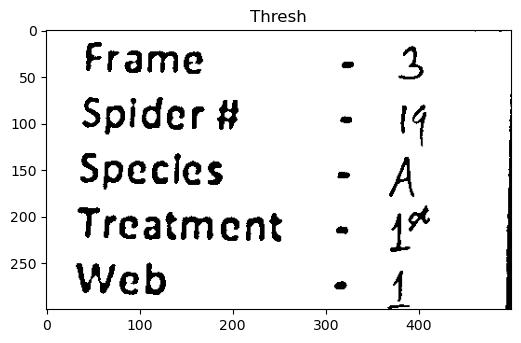

Using CPU. Note: This module is much faster with a GPU.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\adamain\.conda\envs\imgid\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Processing images:   1%|▏         | 1/69 [00:14<15:53, 14.03s/it]

[{'image_path': 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\19 - 1.JPG', 'ocr_text': ['Spider # Spcclcs Treatment Wcb', 'Species - A', 'e', 'Treatment - 1*', 'Web # 1']}]


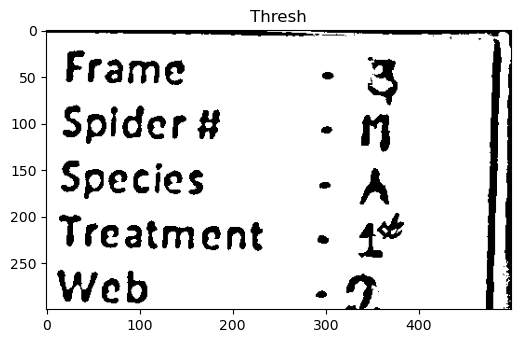

Using CPU. Note: This module is much faster with a GPU.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing images:   3%|▎         | 2/69 [00:28<15:41, 14.05s/it]

[{'image_path': 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\19 - 1.JPG', 'ocr_text': ['Spider # Spcclcs Treatment Wcb', 'Species - A', 'e', 'Treatment - 1*', 'Web # 1']}, {'image_path': 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\19 - 2.JPG', 'ocr_text': ['Frame Spider # 1 Species Treatment ^ Wcb', 'Spider # -M.', 'Species . A', 'Treatment # #', 'Web # a']}]


Processing images:   3%|▎         | 2/69 [00:29<16:42, 14.97s/it]


KeyboardInterrupt: 

In [ ]:
#Problems: Not reading the images correctly, not on the right file directory-- open last used chat w/ gpt and continue the troubleshoot?
ocr_results = []  # to store results for each image

for example in dataset:
    image_path = example["image_path"]
    image = example["image"]  # now you can access both directly

    thresh = targetBox(example["image"])  # or adapt targetBox to accept this
    lines = segment_lines(thresh)
    result = hybrid_ocr(lines)
    ocr_results.append({
        "image_path": image_path,
        "ocr_text": result
    })


